# Turkey

In [155]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

import numpy as np
import math
import pandas as pd

from IPython.display import Image

To do:
    
access 180F of inner of each sweep, display in table with corresponding outer
    
estimate/research ideal turkey temp- outside (upper bound outside of meat burning temp)

validation: thing to compare it to

finish computational essay


## Question

### When cooking a 10 pound turkey, what is the best length of time to cook it for and best oven temperature to cook it at?

With the upcoming Thanksgiving season, the concern of cooking the perfect turkey is on many families’ minds.
If you cook a turkey at too high of an oven temperature, the outside cooks faster than the inside, and can cause burning or undercooking of the inside of the turkey. On the other hand, if you cook a turkey at too low an oven temperature, it takes a very long time to cook, and you do not get a good crispy outside. Also, if you cook a turkey for too little time you risk undercooking and if you cook a turkey for too long it can cause dryness and burning. It’s important to balance time and oven temperature in order to cook a good thanksgiving turkey, and so we wanted to explore the ideal factors.


## Model

We modeled the turkey as a sphere made of two layers. The spherical turkey weighed 10 lbs and has a diameter of 30 centimeters -- both determined from online turkey recipes. The outer layer of the turkey was assumed to have a thickness of 3 cm. The heat of the oven was kept constant within a single run of the simulation, and heat was modeled to be transferred via conduction between the air of the oven and the outer layer of the turkey, and between the outer and inner layers.

In [2]:
def make_system(params, T_oven, T_init, t_end):
    """Make a system object for the turkey model.
    inner is inner temperature of turkey
    outer is outer temperature of turkey
    
    params is the r and C values for thermal compartments
    t_end is when the turkey is taken out of the oven
    )
    
    returns: System object
    """
    #initial temperatures are of the temperature of pre-heated oven
    init = State(T_inner=T_init, T_outer=T_init)

    return System(init=init, t0=0, t_end=t_end, T_oven=T_oven,
                  params = params)

The C value of each layer was estimated as the mass multiplied by the specific heat of turkey meat (3.53 kJ/kg\*K)from ashrae.org's "Thermal Properties of Foods" and the R values were assumed to be the same and were estimated so the temperature of the internal layer over time would match that of an actual turkey being cooked in this paper: http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf
https://www.researchgate.net/file.PostFileLoader.html?id=57dc0df6dc332d6c7a2b0e94&assetKey=AS%3A406964417908742%401474039286881

In [94]:
params = Params(
    r_outer = 0.006, #Km^2/W
    r_inner = 0.006, #Km^2/W
    c_inner = 10450, #J/K
    c_outer = 5330, #J/K
    );

The functions convert_k_to_f to assist in plot clarity. convert_k_to_f converts the kelvin temperatures from calculations into farenheit for plotting.

In [4]:
def convert_k_to_f(k):
    return (k-273)*(9/5) + 32

To calculate the temperature derivative with respect to time of the outer and inner layers (dodt and didt respectively), we used the formulas
Flux = (T_ext - T) / R
And
dT/dt = net flux/C
Where R = thermal resistivity and C = thermal mass.

In [5]:
def slope_func(state, t, system):
    """Makes the differential equations.
    
    state: State (t_inner, t_outer)
    t: time
    system: System object
    
    returns: didt, dodt
    """
    
    unpack(system)
    r_outer, r_inner, c_inner, c_outer = params
    T_inner, T_outer = state
    
    o_flux = (T_oven-T_outer)/r_outer
    i_flux = (T_outer-T_inner)/r_inner
    
    dodt = (o_flux-i_flux)/c_outer
    
    #compute inner temperature change
    didt = i_flux/c_inner
    
    return didt, dodt

The plot results to aid in plotting the validation graph is made below.

In [6]:
def plot_results_validation(inner, outer):
    """Plot the inner and outer temperatures of the Turkey
    
    inner: TimeSeries
    outer: TimeSeries
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    plot(inner_f, '-', color = 'red', label='Inner Temperature')
    plot(outer_f, '-', color = 'blue', label='Outer Temperature')
    
    decorate(xlabel='Minutes',
             ylabel='Temperature (Degrees F)',
             title = 'Cooking Time of a Turkey')

### Validation

To calibrate the r values and verify that the curve for turkey cooking is correct, the inner and outer temperatures of the turkey are plotted and compared to the values from the [article or recipe].

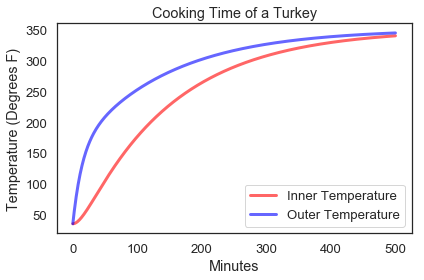

In [7]:
system = make_system(params,450,275,500)
results, details = run_ode_solver(system,slope_func,max_step=1)
plot_results_validation(results.T_inner, results.T_outer)

The plot below is from this article: http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf and was used to calibrate our verfication curve.

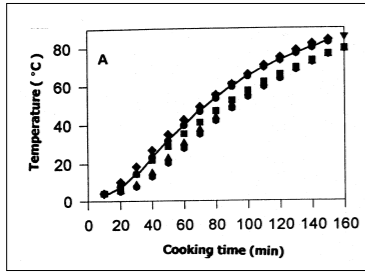

In [19]:
Image("images/turkey_temp_graph.png")

#### Legend: 

#### circle = thigh of 6.8kg calculated values from artile (best fit line matches to this)

#### hexagon = thigh of 7.1kg fresh turkey 

6.8kg is 15 pounds. The graph from the article shows the curve for the inner temperature of a turkey (thigh in this case). The curve roughly matches with our verfication plot. Also, our verfication plot shows the inner temperature of the turkey reaching 180 degrees farenheit at 120 minutes and the article's graph shows the thigh temperature reaching 80 degrees celcius (176 degrees farenheit)at 115-120 minutes.

For additional verfication, this recipe for a 15 pound turkey has the inner temperature of the turkey as degrees farenheit when it is removed from the oven after minutes. For our verification plot, the inner temperature of the turkey is _ degrees farenheit at _ minutes.

### Sweep

Once the temperatures are verified on a graph, a sweepseries of oven temperatures is made. The sweepseries is used to make a graph of the oven temperature and the corresponding inner temperature and outer temperature of the turkey at given times.

In [8]:
def sweep_temp(slope_func, min_temp, max_temp, time):
    '''Sweep oven temperature
    
    min_temp: lowest temperature 
    max_temp: highest temperature
    
    Returns: Sweepseries
    '''
    
    temp_array = linspace(min_temp, max_temp, 5)
    sweep = SweepSeries()
    
    colors = ['red','orange','yellow','green','blue','purple']
    color_counter = 0
    
    for temp in temp_array:
        system=make_system(params,temp,275,time) #make_system(params, T_oven, T_init, t_end)
        results, details = run_ode_solver(system,slope_func,max_step=1)
        plot_results(results.T_inner, results.T_outer, colors[color_counter])
        color_counter += 1
        sweep[temp] = results
    
    return sweep

## Results

Talk about results and stuff.

In [9]:
def plot_results(inner, outer, color):
    """Plot the inner and outer temperatures of the Turkey
    
    inner: TimeSeries
    outer: TimeSeries
    
    """
    inner_f=convert_k_to_f(inner)
    outer_f=convert_k_to_f(outer)
    plot(inner_f, '-', color = color)
    plot(outer_f, '-', color = color)
    
    decorate(xlabel='Minutes',
             ylabel='Temperature')

,values
394.0,T_inner T_outer 0.000000 ...
420.5,T_inner T_outer 0.000000 ...
447.0,T_inner T_outer 0.000000 ...
473.5,T_inner T_outer 0.000000 ...
500.0,T_inner T_outer 0.000000 ...


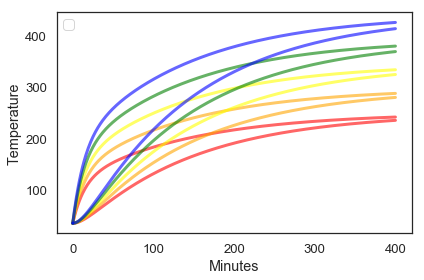

In [10]:
sweep = sweep_temp(slope_func, 394, 500, 400)

In [104]:
def get_min(my_list):
    my_min = np.inf
    for item in my_list:
        if item < my_min:
            my_min = item
    return my_min

my_list = [3,2,7.546,10,2,8]
print(get_min(my_list))

2


In [173]:
def make_results_table(sweep):
    
    inner_list = []
    outer_list = []
    
    #make list of pairings with 180
    for oven_temp in sweep.index:
        
        #get inner temp closest to 180
        off_from_180_list=[]
        for temp in sweep[oven_temp].T_inner:
            #355 is 180 f in k
            off_from_180 = abs(355 - temp)
            if off_from_180 < 1:
                closest_temp = temp
                break
        
        for index in sweep[oven_temp].T_inner.index:
            if sweep[oven_temp].T_inner[index] == closest_temp:
                corresp_index = index
        
        corresp_outer = sweep[oven_temp].T_outer[corresp_index]
        
        inner_list.append(closest_temp)
        outer_list.append(corresp_outer)
    
    my_table = TimeSeries() 
    my_table.inner_temps = inner_list
    my_table.outer_temps = outer_list
    print(my_table.inner_temps)
    print(my_table.outer_temps)
    
    return my_table
    
    
results_table = make_results_table(sweep)

[354.0566736154039, 354.11973344336036, 354.23738467760165, 354.6590610124782, 354.5972759714013]
[371.52157338175965, 383.1372826805825, 394.750908721919, 406.4642004870532, 417.78127253276284]


,values


In [118]:
int(3.5)

3

### From thermal properities of food pdf (in google doc): 
Turkey specific heat above freezing 3.53 kJ/(kg·K)
Turkey, breast 0.496 W/(m·K) thermal conductivity at 3 degrees C

### From turkey cooking article:
http://www.greenbuildingadvisor.com/sites/default/files/Modeling%20Heat%20Transfer%20of%20Turkeys.pdf data from turkey
 118°C oven temp, with the oven at room temperature starting their experiment
 thermal conductivity 0.461 W/m K
 surface heat transfer coefficient of 19.252 W/m2K

https://www.allrecipes.com/recipe/166160/juicy-thanksgiving-turkey/
This is the recipe we got "180" from